/home/dhruv/misc-projects/stingray/stingray/largememory.py:25: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  warnings.warn(


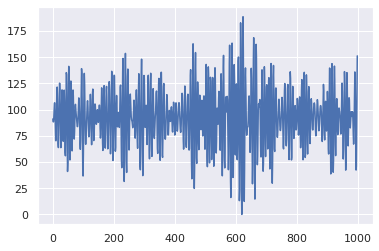

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from stingray import Powerspectrum, Multitaper, Lightcurve, plot_dB
from stingray.bispectrum import Bispectrum
from scipy import signal
import seaborn as sns
sns.set_theme(style='darkgrid')

np.random.seed(100)  # For consistency
coeff = np.array([2.7607, -3.8106, 2.6535, -0.9238])
ar4 = np.r_[1, -coeff]  # For use with scipy.signal
N = 1000


freq, h = signal.freqz(b=1.0, a=ar4, worN=N, fs=1)  # True PSD of AR(4)
psd = (h * h.conj()).real

data = signal.lfilter([1.0], ar4, np.random.randn(N)
                      )  # 1000 AR(4) data samples
# stingray.Powerspectrum does not accept negative values
data += abs(data.min())
times = np.arange(N)


lc2 = Lightcurve(time=times, counts=data)
lc2.plot()

In [2]:
from stingray.utils import create_window
from stingray import AveragedPowerspectrum

def welch_averaged_powerspectrum(times, data, segment_size, norm='none'):
    length = len(data)
    if length%segment_size != 0:
        print('Enter segment_size so that is perfectly divides the data to prevent data loss.')
    
    number_segments = length//segment_size
    windows = create_window(segment_size, 'welch')
    windows = np.tile(windows, number_segments)
    tapered_data = windows*data
    
    lc = Lightcurve(time=times, counts=tapered_data)
    aps = AveragedPowerspectrum(lc, norm=norm, segment_size=segment_size)
    
    return aps


In [3]:
# There is some discrepancy between normalizations
ps = Powerspectrum(lc2, norm='none')
# These norm params give the closest resemblance to paper
mtp = Multitaper(lc2, norm='none', adaptive=True, Fs=1)

segment_size=100
tapered_aps = welch_averaged_powerspectrum(times, data, segment_size, norm='none')
aps =  AveragedPowerspectrum(lc2, segment_size=segment_size, norm='none')

10it [00:00, 30.36it/s]
10it [00:00, 48.15it/s]


/home/dhruv/miniconda3/envs/stingray/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/dhruv/miniconda3/envs/stingray/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/dhruv/miniconda3/envs/stingray/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


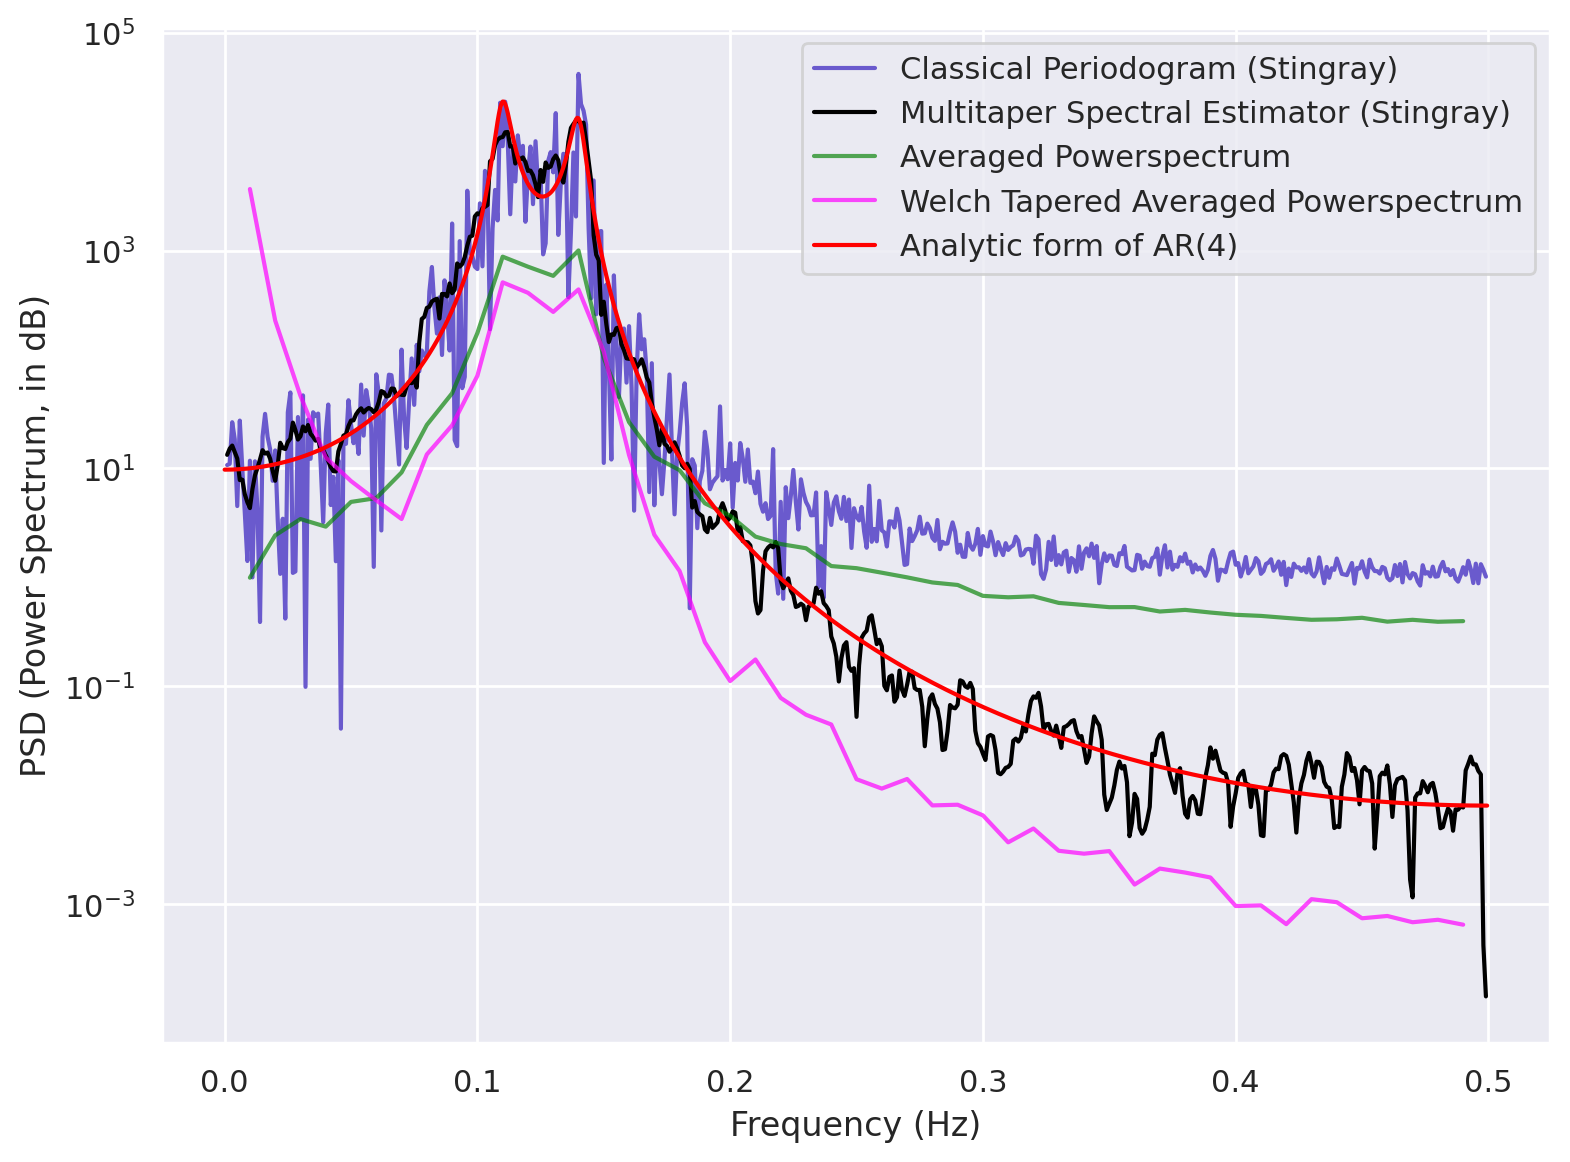

In [4]:
Fs = 1
# Normalizing as per nitime gives a better fit
custom_norm_ps = ps.unnorm_power / (Fs * data.shape[-1])
# Than using Stingray's 'abs' norm
custom_norm_mtp = mtp.unnorm_power / (Fs * data.shape[-1])
custom_norm_aps = aps.unnorm_power / (Fs * data.shape[-1])
custom_norm_tapered_aps = tapered_aps.unnorm_power / (Fs * data.shape[-1])

fig = plt.figure(dpi=200, figsize=[6.4*1.4, 4.8*1.4])
plt.plot(ps.freq, custom_norm_ps, label='Classical Periodogram (Stingray)',
         color='slateblue')
plt.plot(mtp.freq, custom_norm_mtp, label='Multitaper Spectral Estimator (Stingray)',
         color='black')
plt.plot(aps.freq, custom_norm_aps, label='Averaged Powerspectrum',
         color='green', alpha=0.66)
plt.plot(tapered_aps.freq, custom_norm_tapered_aps, label='Welch Tapered Averaged Powerspectrum',
         color='magenta', alpha=0.7)
plt.plot(freq, psd, label='Analytic form of AR(4)', color='red')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (Power Spectrum, in dB)')
plt.yscale('log')
plt.legend()